In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']

import numpy as np
import healpy as hp
import scipy
from scipy import special as ss
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import math
import NX01_bayesutils as bu
import NX01_utils as utils

# IPTA MDC injection

## Injected map

In [3]:
clm_inj = np.load('nanogravTests_pointAnis.npy')

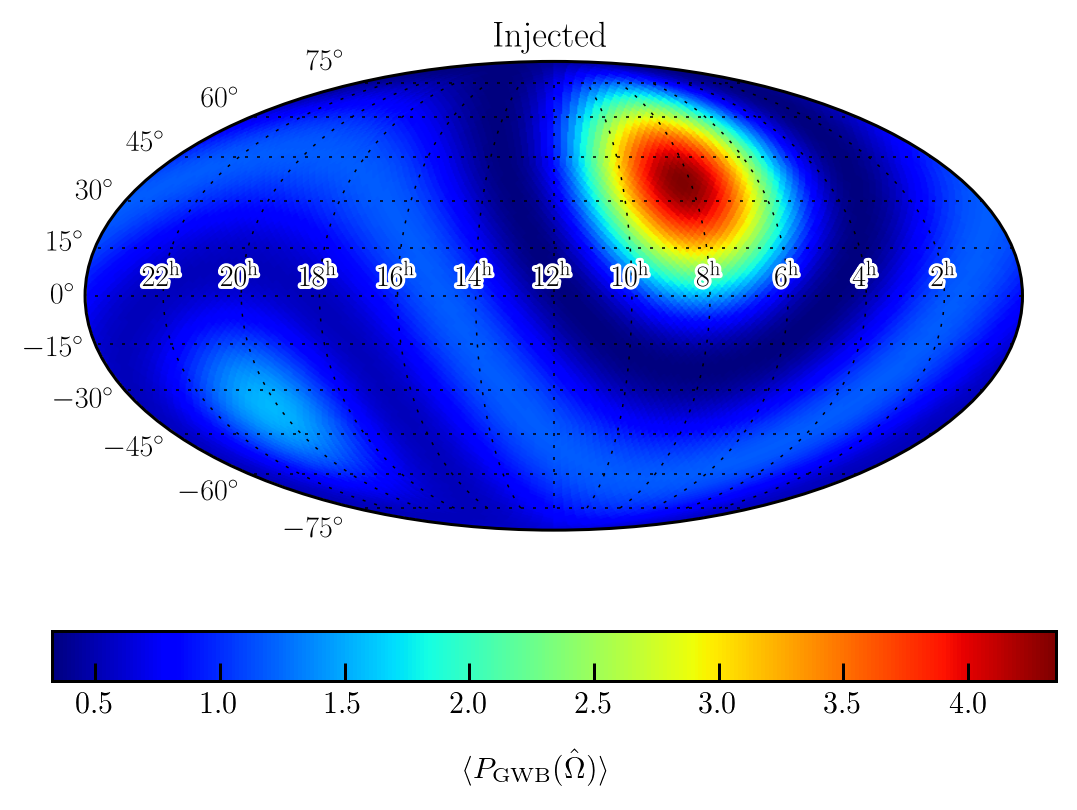

In [12]:
map_inj = bu.makeSkyMap(clm_inj[1:],lmax=4,nside=32)
plt.title('Injected')
plt.savefig('nanoAnisTests_pointInj.png',bbox_inches='tight',dpi=400)

## Spherical harmonic analysis: produce posterior averaged skymap

In [13]:
clm_chain = np.loadtxt('chains_mdc1_anisSim_hotspot/nanograv_gwbdetect_Lmax4_gamVary_reddetectpowerlaw_nmodes15/chain_1.0.txt')

In [14]:
print clm_chain.shape
print clm_chain[:,-3-(4+1)**2:-4].shape

(25700, 102)
(25700, 24)


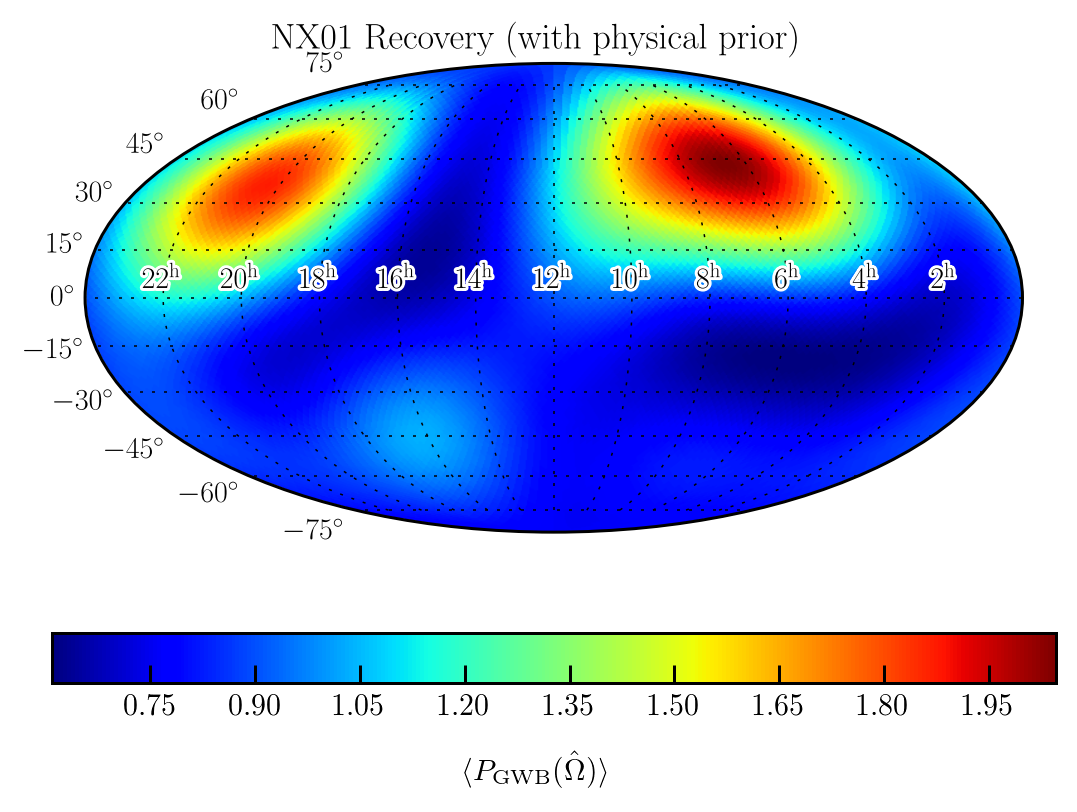

In [15]:
map_expected = bu.makeSkyMap(clm_chain[:,-3-(4+1)**2:-4],lmax=4,nside=32)
plt.title('NX01 Recovery (with physical prior)')
plt.savefig('nanoAnisTests_pointRecvr.png',bbox_inches='tight',dpi=400)

## Point-source anisotropy: produce posterior averaged skymap

In [5]:
pointSrc_chain = np.loadtxt('chains_mdc1_anisSim_hotspot/nanograv_gwbdetect_pointSrc_gamVary_reddetectpowerlaw_nmodes15/chain_1.0.txt')

Sigma is 68.754935 arcmin (0.020000 rad) 
-> fwhm is 161.905500 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


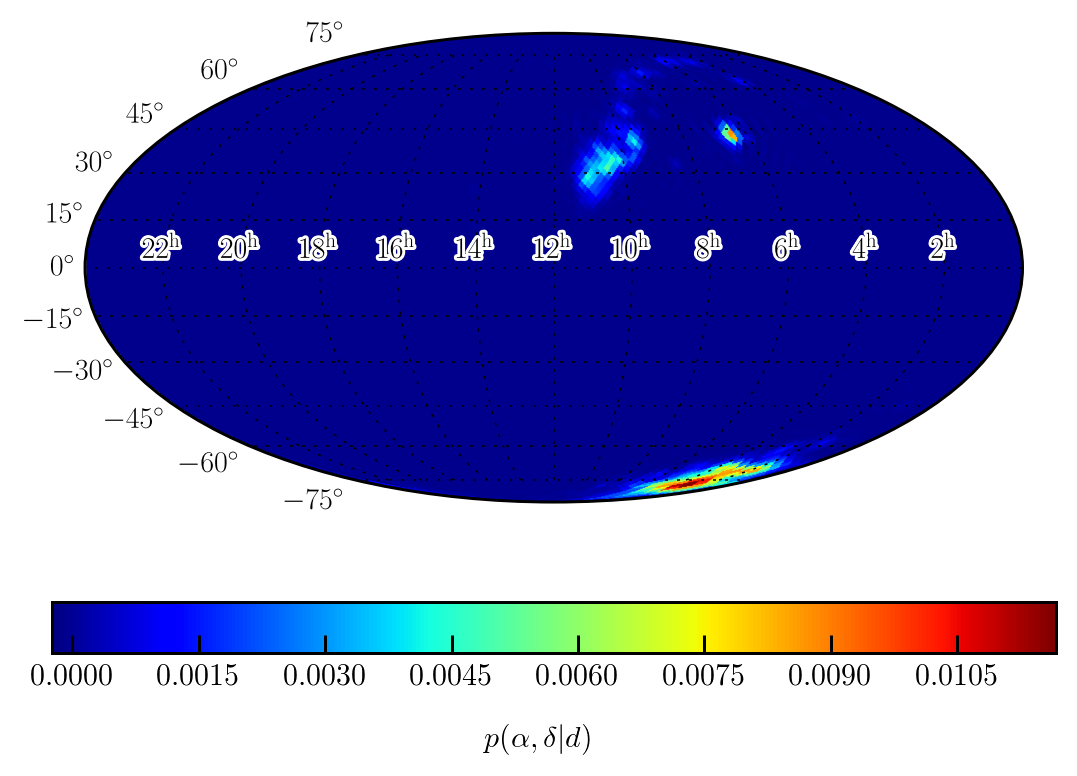

In [11]:
#map_point = bu.plotSkyMap(pointSrc_chain[:,74], np.pi/2. - np.arccos(pointSrc_chain[:,75]), nside=64, cmap='jet', outfile='skymap.pdf')
map_point = bu.plotSkyMap(pointSrc_chain[:,74] + np.pi, np.pi/2. - (np.pi - np.arccos(pointSrc_chain[:,75])), nside=32, cmap='jet', outfile='skymap.pdf')

# NANOGrav-type data with hotspot

In [11]:
clm_chain = np.loadtxt('nemo_nano9yr_anis/chains_nano9yr_anisSim_hotspot/nanograv_gwbdetect_Lmax4_gamVary_reddetectpowerlaw_nmodes15/chain_1.0.txt')

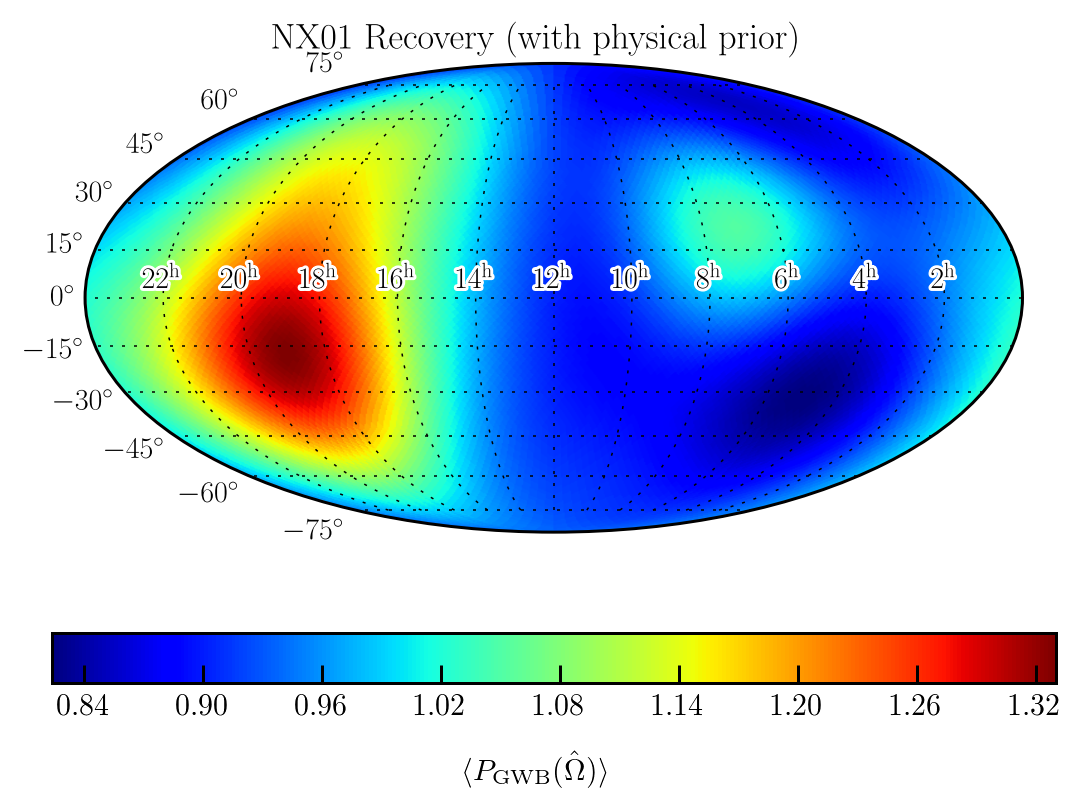

In [13]:
map_expected = bu.makeSkyMap(clm_chain[:,-3-(4+1)**2:-4],lmax=4,nside=32)
plt.title('NX01 Recovery (with physical prior)')
#plt.savefig('nanoAnisTests_pointRecvr.png',bbox_inches='tight',dpi=400)

In [14]:
clm_chain.shape

(226100, 66)

In [15]:
import corner

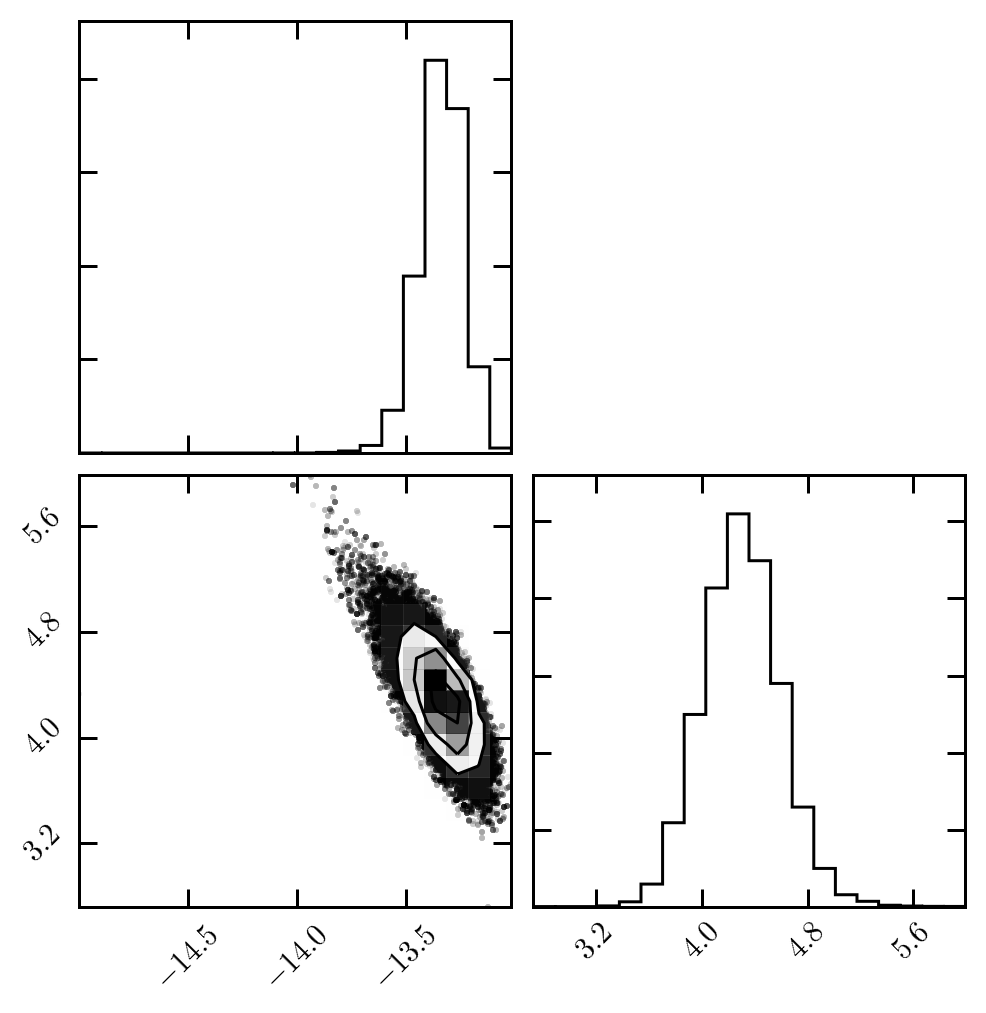

In [16]:
figure = corner.corner(clm_chain[:,[36,37]])